In [39]:
# from google.colab import drive
# drive.mount('/content/drive')  # use this if you are using google colab

In [40]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import pickle, os
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def load_dataset(name_file):

    desired_directory = '.' # Replace with your desired directory path

    file_path = os.path.join(desired_directory, name_file) 

    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f)

    return data_dict


In [42]:
loaders_dict = load_dataset(f"dataset-flowers102-features.pkl")
x_train = loaders_dict["x_train"]
x_test = loaders_dict["x_test"]
y_train = loaders_dict["y_train"]
y_test = loaders_dict["y_test"]
print(f"x_train:{x_train.shape}, y_train:{y_train.shape}")
print(f"x_test:{x_test.shape}, y_test:{y_test.shape}")


x_train:(4094, 512), y_train:(4094,)
x_test:(4095, 512), y_test:(4095,)


## clustering images

In [43]:
k_number = 50
kmeans = KMeans(n_clusters=k_number)
clusters = kmeans.fit_predict(x_train)
centroids = kmeans.cluster_centers_

c:\Users\ewint\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## find nearest clusters neighbors

### find nearest clusters and their indices

In [44]:
def find_nearest_clusters_neighbors(x_train, x_test, k):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train, range(len(x_train)))
    nearest_indices = knn_classifier.kneighbors(x_test, n_neighbors=k, return_distance=False)
    # nearest_neighbors = x_train[nearest_indices]
    # nearest_neighbors = [x_train[indices] for indices in nearest_indices]

    return nearest_indices

### get the data of nearest clusters

In [45]:
def gather_clusters_data(k_number, clusters):
    clusters_data = {i: [] for i in range(k_number)}
    clusters_data_labels = {i: [] for i in range(k_number)}
    for i, label in enumerate(clusters):
        clusters_data[label].append(x_train[i])
        clusters_data_labels[label].append(y_train[i])
    return clusters_data, clusters_data_labels

In [46]:
def get_nearest_clusters_data(nearest_clusters_indices, clusters_data, clusters_data_labels):
    # Access data points in the cluster with centroid index 'nearest_clusters_indices'
    all_data_in_nearest_clusters = []
    all_labels_in_nearest_clusters = []
    for indices in nearest_clusters_indices:
        data_in_nearest_clusters = []
        labels_in_nearest_clusters = []
        for index in indices:
            data_in_nearest_clusters.extend(clusters_data[index])
            labels_in_nearest_clusters.extend(clusters_data_labels[index])
        all_data_in_nearest_clusters.append(data_in_nearest_clusters)
        all_labels_in_nearest_clusters.append(labels_in_nearest_clusters)
    return all_data_in_nearest_clusters, all_labels_in_nearest_clusters

## classify using data in nearest clusters

In [47]:
def classify_knn(x_train, y_train, x_test, y_test, k):
    y_preds = []
    for data_train, label_train, one_data_test in zip(x_train, y_train, x_test):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(data_train, label_train)
        y_preds.append(knn_classifier.predict([one_data_test]))
    
    accuracy = accuracy_score(y_test, y_preds)
    score = ( accuracy * 100 ) + ( k * (-0.2))
    return y_preds, accuracy, score

## running classifing steps using different amout of *k_nearest_clusters* and *k_nearest_data*

In [48]:
first_k_results = {}
k_clusters = range(3, 15, 2)
k_data = range(2, 15, 5)

for k_nearest_clusters in k_clusters:
    print("-", k_nearest_clusters)
    second_k_results = {} # first element in each touple is accuracy and the second one is score
    # find nearest klisters neighbors----------------------------------
    x_train_clusters = centroids
    nearest_clusters_indices = find_nearest_clusters_neighbors(x_train_clusters, 
                                                            x_test, 
                                                            k=k_nearest_clusters)
    # gather clusters data---------------------------------------------
    clusters_data, clusters_data_labels = gather_clusters_data(k_number, clusters)
    # get nearest clusters data----------------------------------------
    all_data_in_nearest_clusters, all_labels_in_nearest_clusters = get_nearest_clusters_data(nearest_clusters_indices, 
                                                                                    clusters_data, 
                                                                                    clusters_data_labels)
    for k_nearest_data in k_data:
        if k_nearest_data > len(all_data_in_nearest_clusters):
            break

        print("-   -", k_nearest_data)
        # classify test data using knn-------------------------------------
        x_train_data = all_data_in_nearest_clusters
        y_train_data = all_labels_in_nearest_clusters
        predictions, accuracy, score = classify_knn(x_train_data, y_train_data, x_test, y_test, k=k_nearest_data)
        # result-----------------------------------------------------------
        second_k_results[k_nearest_data] = (accuracy*100, score)
    
    first_k_results[k_nearest_clusters] = second_k_results
    print(first_k_results[k_nearest_clusters])
print(np.array(first_k_results))    

- 3
-   - 2
-   - 7
-   - 12
{2: (81.78266178266178, 81.38266178266177), 7: (83.98046398046398, 82.58046398046397), 12: (82.90598290598291, 80.5059829059829)}
- 5
-   - 2
-   - 7
-   - 12
{2: (82.14896214896214, 81.74896214896214), 7: (84.71306471306471, 83.3130647130647), 12: (83.61416361416362, 81.21416361416361)}
- 7
-   - 2
-   - 7
-   - 12
{2: (82.14896214896214, 81.74896214896214), 7: (85.006105006105, 83.606105006105), 12: (84.1025641025641, 81.7025641025641)}
- 9
-   - 2
-   - 7
-   - 12
{2: (82.19780219780219, 81.79780219780218), 7: (85.07936507936508, 83.67936507936507), 12: (84.42002442002442, 82.02002442002441)}
- 11
-   - 2
-   - 7
-   - 12
{2: (82.27106227106226, 81.87106227106226), 7: (85.25030525030525, 83.85030525030524), 12: (84.59096459096459, 82.19096459096458)}
- 13
-   - 2
-   - 7
-   - 12
{2: (82.29548229548229, 81.89548229548228), 7: (85.25030525030525, 83.85030525030524), 12: (84.59096459096459, 82.19096459096458)}
{3: {2: (81.78266178266178, 81.38266178266177)

## plot clusters

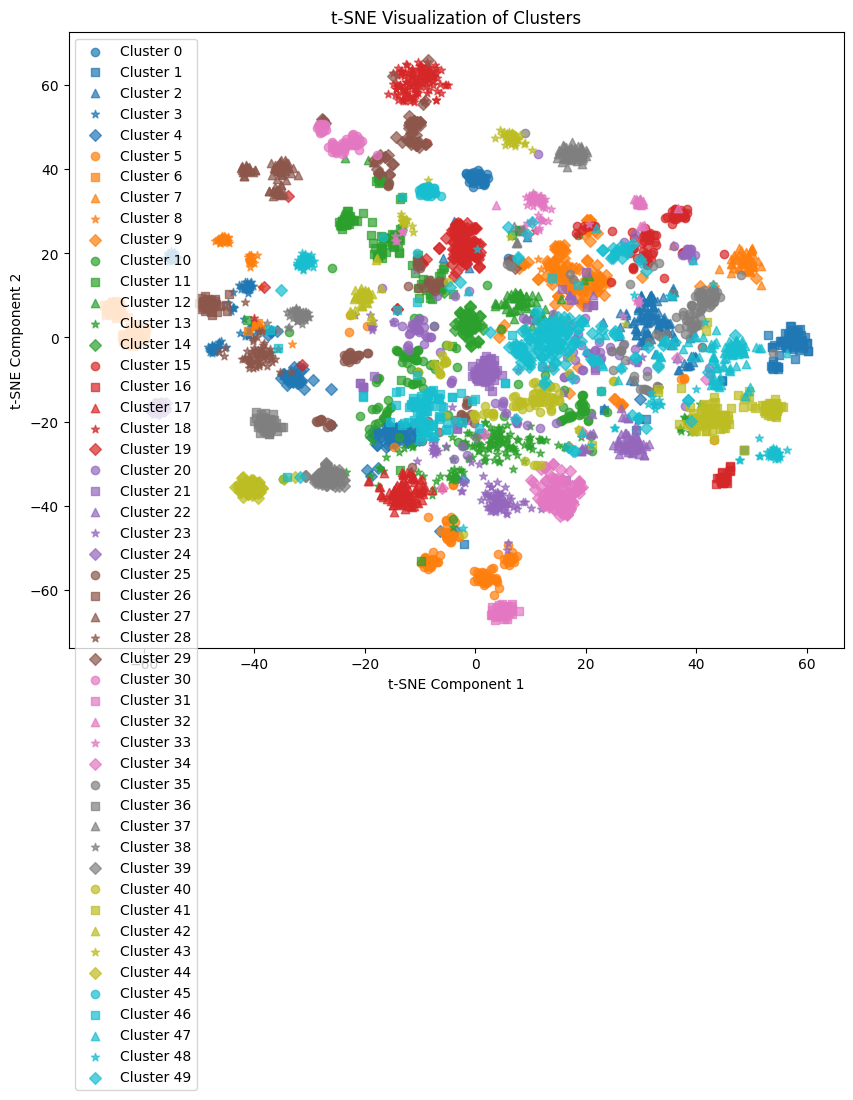

In [49]:
data = x_train
labels = clusters
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(data)

colormap = plt.get_cmap('tab10')  
markers = ['o', 's', '^', '*', 'D']

plt.figure(figsize=(10, 8))

for i, cluster_label in enumerate(np.unique(labels)):
    cluster_indices = np.where(labels == cluster_label)
    plt.scatter(
        embedded_data[cluster_indices, 0],
        embedded_data[cluster_indices, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        marker=markers[i % len(markers)],
        color=colormap(i / len(np.unique(labels)))
    )

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [51]:
first_k_results

{3: {2: (81.78266178266178, 81.38266178266177),
  7: (83.98046398046398, 82.58046398046397),
  12: (82.90598290598291, 80.5059829059829)},
 5: {2: (82.14896214896214, 81.74896214896214),
  7: (84.71306471306471, 83.3130647130647),
  12: (83.61416361416362, 81.21416361416361)},
 7: {2: (82.14896214896214, 81.74896214896214),
  7: (85.006105006105, 83.606105006105),
  12: (84.1025641025641, 81.7025641025641)},
 9: {2: (82.19780219780219, 81.79780219780218),
  7: (85.07936507936508, 83.67936507936507),
  12: (84.42002442002442, 82.02002442002441)},
 11: {2: (82.27106227106226, 81.87106227106226),
  7: (85.25030525030525, 83.85030525030524),
  12: (84.59096459096459, 82.19096459096458)},
 13: {2: (82.29548229548229, 81.89548229548228),
  7: (85.25030525030525, 83.85030525030524),
  12: (84.59096459096459, 82.19096459096458)}}